# 01 LT control replicate 2 preprocessing

Run with this command in docker container

docker run 
--rm 
-d 
--name demuxEM 
-p 8881:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
pegasuspy_scanpy:vs1


followed the workflow in this jupyter notebook: 
(https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb)
updated with the new preprocessing from the female cell regression.

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scanpy.external as sce

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)
# plt.rcParams['figure.figsize']=(5,5) #rescale figures

In [4]:
adata = sc.read_10x_mtx(
    './raw_data/A_ct/outs/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)

... reading from cache file cache/raw_data-A_ct-outs-filtered_feature_bc_matrix-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 6111 × 31053 
    var: 'gene_ids', 'feature_types'

## 2) Preprocessing  

simple preprocessing recipe adapted from the scanpy tutorial

In [7]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
mito_genes = adata.var_names.str.startswith('mt-')
# replaced the "MT" with small caps "mt" otherwise couldn't be found
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

from scipy.sparse import issparse #needed for the sparse matrix

# version for sparse matrix
if issparse(adata.X): 
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1      
    
# version for non-sparse matrix
else:
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1)

# Filter cells that exceed 4000 counts (doublets) and have more than 20% mitochondrial counts (dead)
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.1, :]

sc.pp.filter_genes(adata, min_counts=1) # drop genes that have less than one count

# normalize to 10K counts/cell and logtransform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata

filtered out 10 cells that have less than 200 genes expressed
filtered out 15283 genes that are detected in less than 3 cells
filtered out 3 genes that are detected in less than 1 counts


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 5334 × 15767 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts'
    uns: 'log1p'

# filtered out some cells that were dividing

# got the cell IDs from clustering from a previous sheet. 
c4_cellindex = ['AAAGAACAGTGCCAGA-1',
 'AAAGGGCAGGCATGGT-1',
 'AAGATAGTCCATCTGC-1',
 'CAAGAGGGTAACCAGG-1',
 'CATTCTACACTATCGA-1',
 'CCTGCATGTCCGTACG-1',
 'CTCTCAGCATGGTGGA-1',
 'CTTTCAACAGAACTCT-1',
 'GAAGTAATCTGGTGCG-1',
 'TCACGCTGTATTAAGG-1',
 'TGATCTTCAAAGACGC-1',
 'TGGATGTGTCATCTAG-1',
 'TTGAGTGAGGAGATAG-1']


filtered_cells = list(set(list(adata.obs_names)) - set(c4_cellindex))
adata = adata[filtered_cells, :]

## 3) Select variable genes for downstream analysis

In [8]:
adata.raw = adata

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [10]:
# number of variable genes
np.sum(adata.var['highly_variable'])

2067

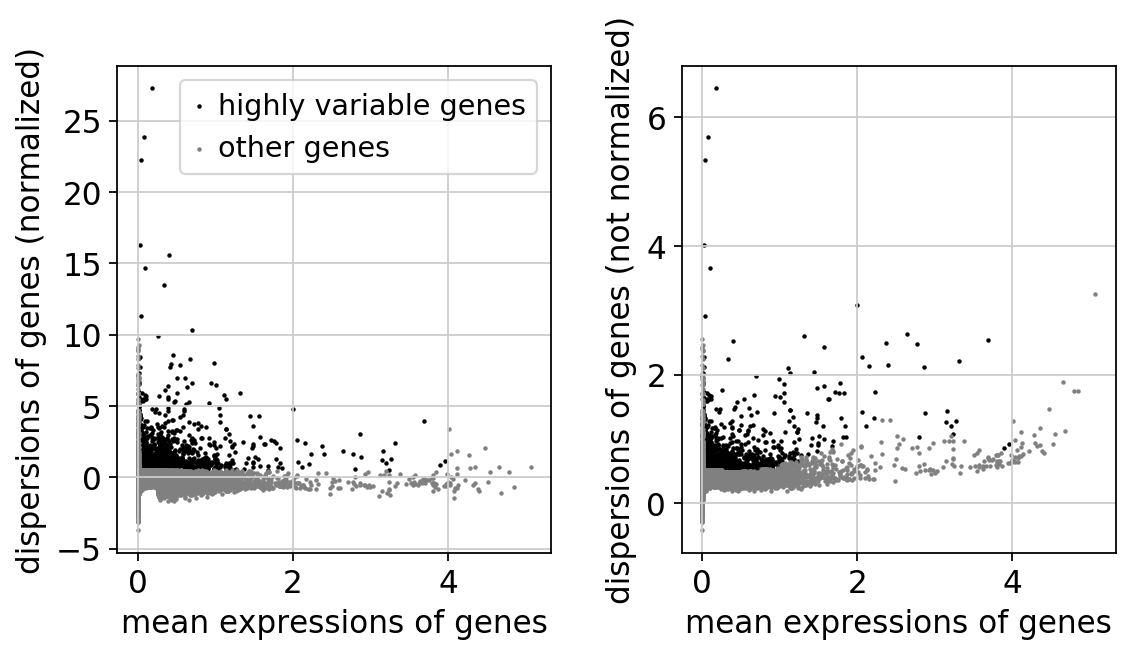

In [11]:
sc.pl.highly_variable_genes(adata)

In [12]:
adata = adata[:, adata.var['highly_variable']]

In [13]:
adata #this now only contains the most variable genes

View of AnnData object with n_obs × n_vars = 5334 × 2067 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## 4) Regress out female cells + scale

I will used the gene Xist for identifying female cells. Xist is a long non coding RNA that is expressed in all cells to silence one of the two X chromosomes in female cells.
More information on Xist: https://en.wikipedia.org/wiki/XIST

(array([2.382e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        1.300e+01, 1.100e+01, 2.700e+01, 1.400e+01, 1.200e+01, 5.000e+00,
        7.000e+00, 4.000e+00, 2.000e+00, 1.100e+01, 1.400e+01, 1.100e+01,
        2.100e+01, 3.600e+01, 3.600e+01, 6.000e+01, 8.500e+01, 1.270e+02,
        1.800e+02, 2.170e+02, 2.400e+02, 3.180e+02, 3.480e+02, 3.550e+02,
        2.670e+02, 2.180e+02, 1.390e+02, 6.800e+01, 4.300e+01, 3.600e+01,
        1.000e+01, 6.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.        , 0.10337243, 0.20674486, 0.3101173 , 0.41348973,
        0.51686215, 0.6202346 , 0.723607  , 0.82697946, 0.93035185,
        1.0337243 , 1.1370968 , 1.2404692 , 1.3438416 , 1.447214  ,
        1.5505865 , 1.6539589 , 1.7573314 , 1.8607037 , 1.9640762 ,
        2.0674486 , 2.170821  , 2.2741935 , 2.3775659 , 2.4809384 ,
        2.5843108 , 2.687683  , 2.79

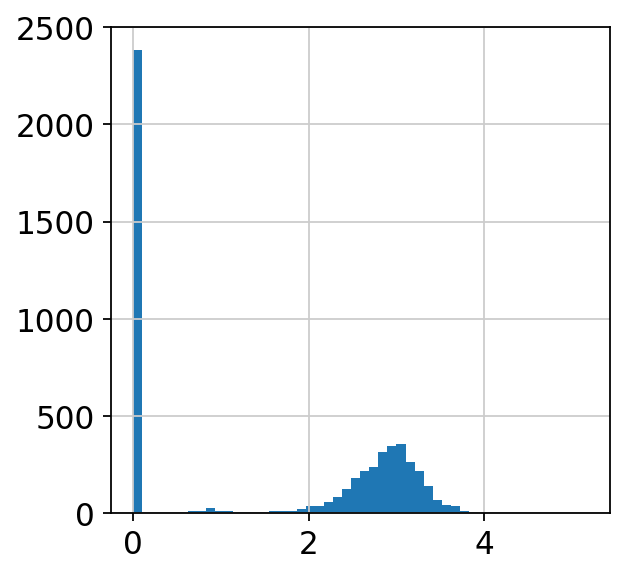

In [14]:
# plots histogram of Xist (int or not doesn't matter)

plt.hist(adata[: , 'Xist'].X.toarray(), bins=50)

In [15]:
adata.obs['Female'] = adata[: , 'Xist'].X.toarray() > 0 # make a column in adata.obs to identify female cells
adata.obs['rXist'] = adata[: , 'Xist'].X.toarray() + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 
adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype

Trying to set attribute `.obs` of view, copying.


In [16]:
#regresses out Xist from adata 
sc.pp.regress_out(adata, ['rXist'])

regressing out ['rXist']
    sparse input is densified and may lead to high memory use


... storing 'feature_types' as categorical
/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


    finished (0:00:13)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. this makes the PCA run better 

In [17]:
sc.pp.scale(adata, max_value=10)

Save the result.

## 5) PCA

Compute PCA and make a scatter plot.

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)


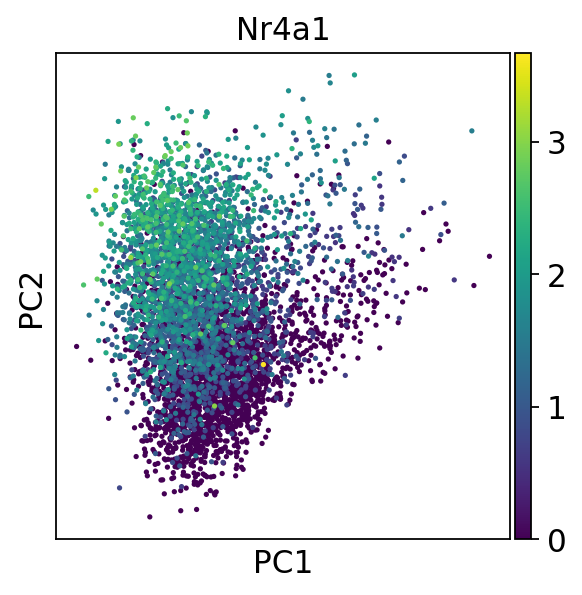

In [19]:
sc.pl.pca(adata, color='Nr4a1')

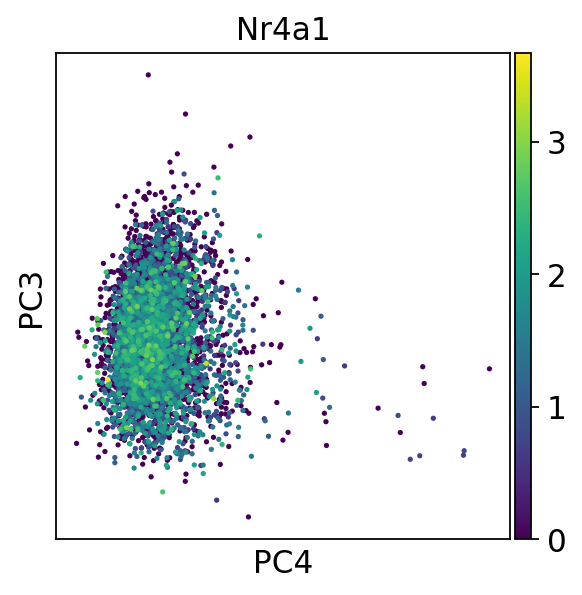

In [20]:
sc.pl.pca(adata, color='Nr4a1', components='4,3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

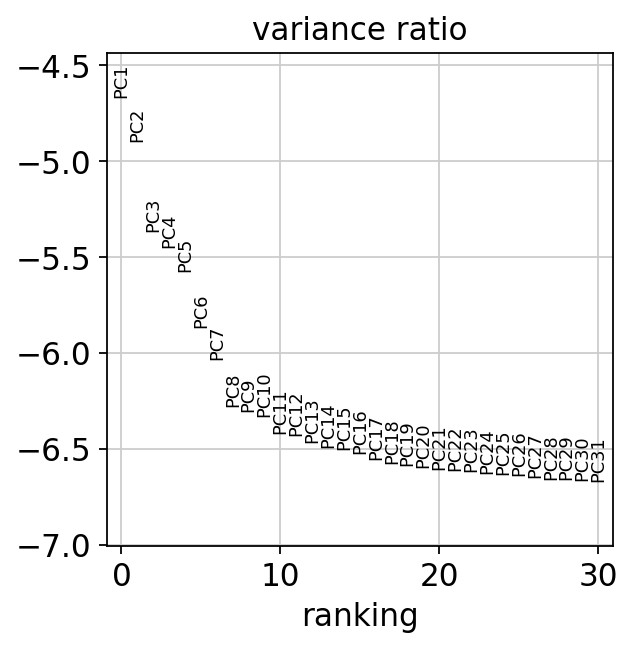

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

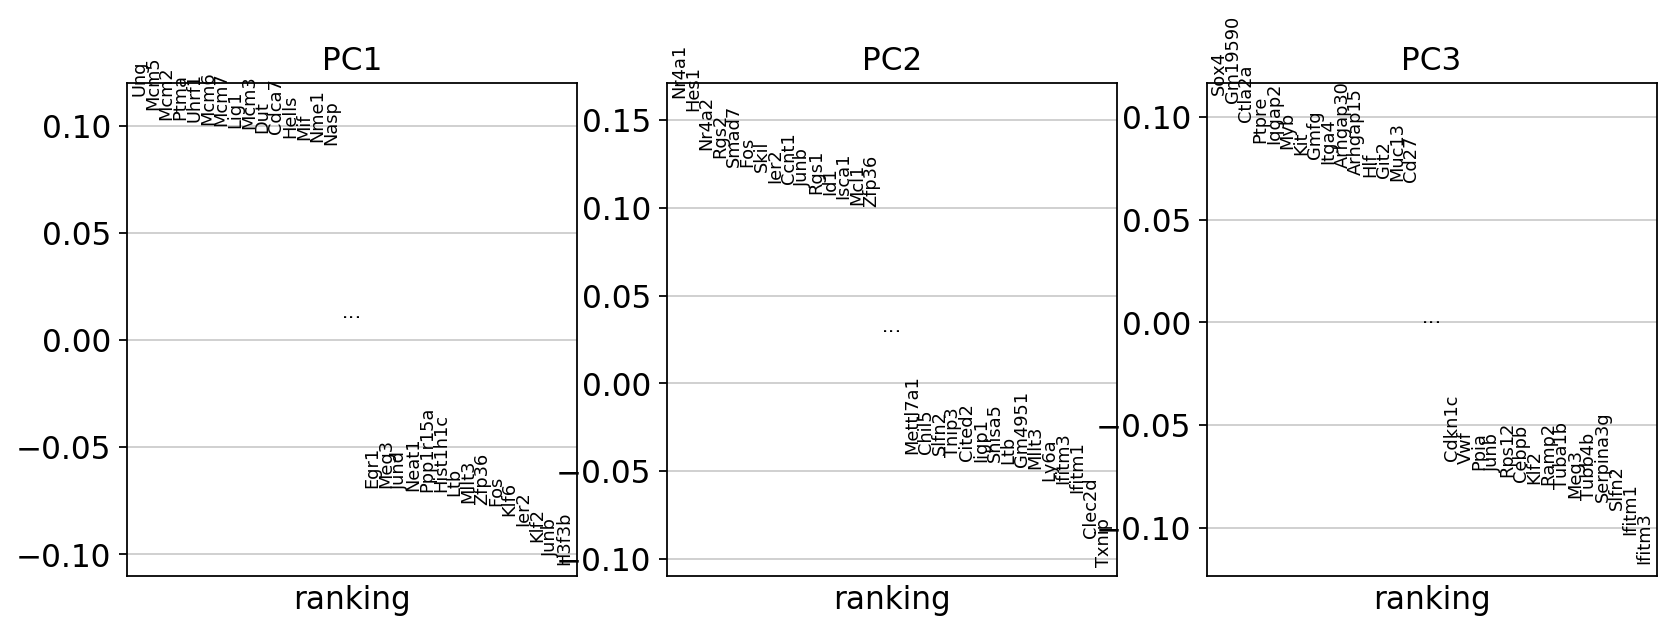

In [22]:
sc.pl.pca_loadings(adata)

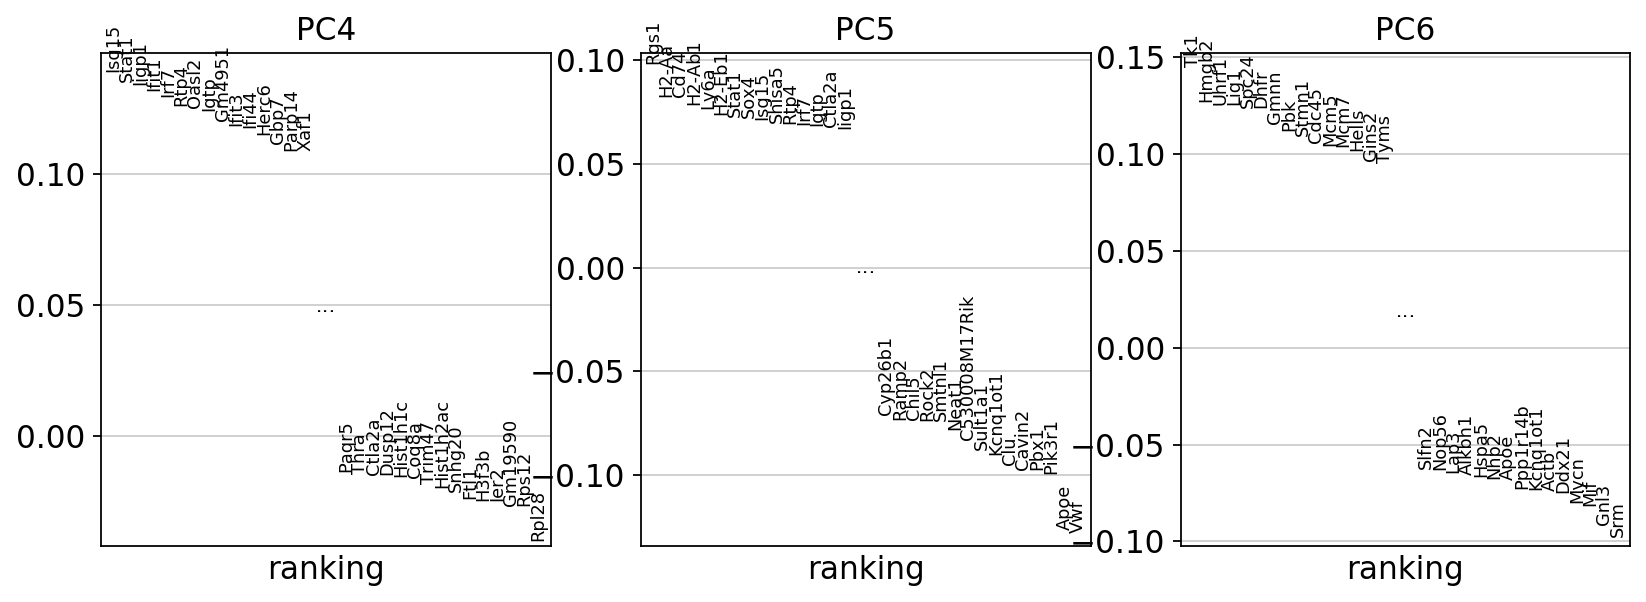

In [23]:
list_pcs= [4,5,6]
sc.pl.pca_loadings(adata, components= list_pcs)

In [24]:
adata

AnnData object with n_obs × n_vars = 5334 × 2067 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Female', 'rXist', 'Female_cat'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 6) Calculate best neigborhood and cluster combination - Leiden clustering

Compute the best clustering outcomes using Silhouette and Davies Boulding scores

In [25]:
## make loop to save different silhouette scores and Davies Bouldin scores in a dataframe

from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from tqdm import tnrange, tqdm_notebook
from time import sleep
import warnings


sc.settings.verbosity = 0   ### suppress output of scanpy
warnings.filterwarnings('ignore') # suppress Warnings
results_df=[]
results_df = pd.DataFrame(columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould'])

for k in tnrange(5, 50, 5, desc ='1st loop'):
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=40);
    sc.tl.umap(adata);
    
    for i in tqdm_notebook(range(20, 150, 10), desc ='2nd loop', leave=False):
        j = i/100
        sc.tl.leiden(adata, resolution=j);
        sc.tl.rank_genes_groups(adata, 'leiden')
        silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'])
        davies_bouldin_avg = davies_bouldin_score(adata.obsm['X_pca'], adata.obs['leiden'])
        results_df = results_df.append(pd.DataFrame([[k, j, max(adata.obs['leiden']), silhouette_avg, davies_bouldin_avg]], columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould']))
        sleep(0.01)

In [26]:
results_df['number_of_clusters'] = results_df['number_of_clusters'].astype(float) + 1 
# need to change the object type louvain clusters are saved as object not float
# need to add 1 because it python starts counting at 0 and the total number of clusters is 1 + max

results_df

KNN  resolution  number_of_clusters       sil  davie_bould
0    5         0.2                 3.0  0.135912     1.727792
0    5         0.3                 4.0  0.067370     2.976414
0    5         0.4                 4.0  0.067386     3.010486
0    5         0.5                 7.0  0.035432     3.213699
0    5         0.6                 8.0  0.004375     3.178635
..  ..         ...                 ...       ...          ...
0   45         1.0                 8.0  0.037045     3.257166
0   45         1.1                 9.0  0.025883     3.389889
0   45         1.2                 9.0  0.029117     3.461222
0   45         1.3                10.0  0.024734     3.469554
0   45         1.4                10.0  0.022056     3.516862

[117 rows x 5 columns]

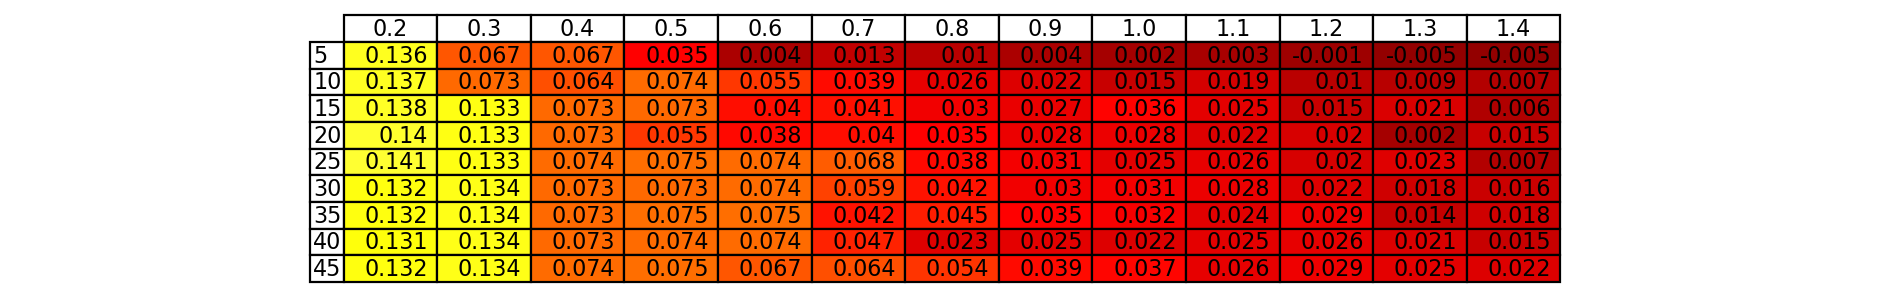

In [27]:
# Make a colored table with the silhouette scores
piv_sil = results_df.pivot(index='KNN', columns='resolution', values='sil')
vals = np.around(piv_sil.values,3) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-0.05, vals.max()+0.05)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_sil.index, colLabels=piv_sil.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)
plt.show()

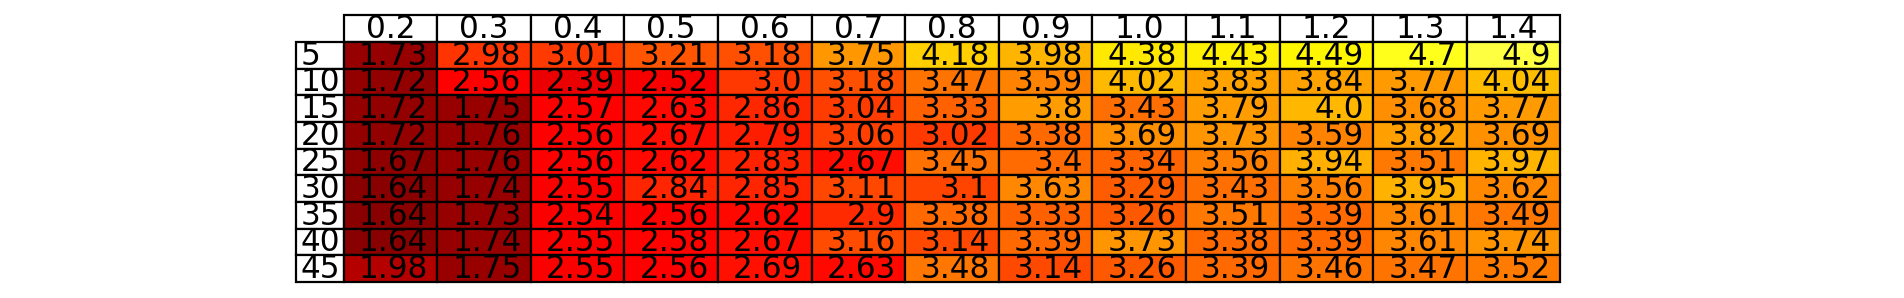

In [28]:
# Make a colored table with the Davies Bouldin scores
piv_DB = results_df.pivot(index='KNN', columns='resolution', values='davie_bould')

vals = np.around(piv_DB.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_DB.index, colLabels=piv_DB.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

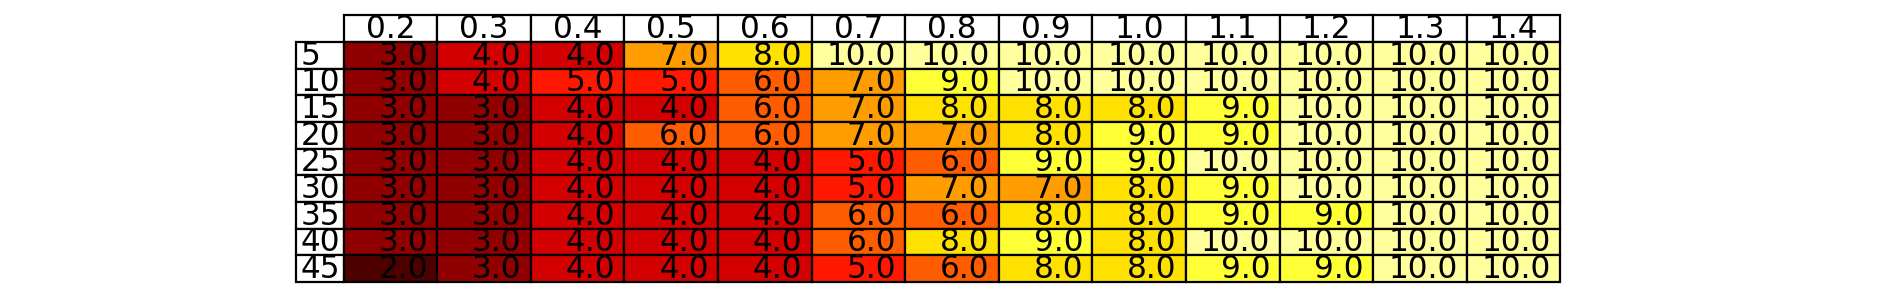

In [29]:
# Make a colored table with the number of clusters
piv_clust = results_df.pivot(index='KNN', columns='resolution', values='number_of_clusters')

vals = np.around(piv_clust.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_clust.index, colLabels=piv_clust.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

In [30]:
max_sil = results_df[results_df.groupby('number_of_clusters')['sil'].transform('max') == results_df['sil']].sort_values(by=['number_of_clusters'])
max_sil

KNN  resolution  number_of_clusters       sil  davie_bould
0  45         0.2                 2.0  0.131915     1.975063
0  25         0.2                 3.0  0.141095     1.670453
0  35         0.6                 4.0  0.075314     2.618198
0  10         0.5                 5.0  0.074143     2.515733
0  20         0.5                 6.0  0.054672     2.669349
0  30         0.8                 7.0  0.042356     3.103631
0  45         0.9                 8.0  0.038533     3.139419
0  25         0.9                 9.0  0.031452     3.397198
0  40         1.2                10.0  0.025854     3.386939

plot the maximum values for Silhouette score and minimum values from Davies-Bouldin index

In [31]:
min_db = results_df[results_df.groupby('number_of_clusters')['davie_bould'].transform('min') == results_df['davie_bould']].sort_values(by=['number_of_clusters'])
min_db

KNN  resolution  number_of_clusters       sil  davie_bould
0  45         0.2                 2.0  0.131915     1.975063
0  35         0.2                 3.0  0.132487     1.636970
0  35         0.4                 4.0  0.073297     2.544031
0  10         0.4                 5.0  0.064118     2.388809
0  20         0.5                 6.0  0.054672     2.669349
0  20         0.8                 7.0  0.034747     3.024490
0  45         0.9                 8.0  0.038533     3.139419
0  25         1.0                 9.0  0.024692     3.339115
0  40         1.1                10.0  0.024736     3.378097

<function matplotlib.pyplot.show(*args, **kw)>

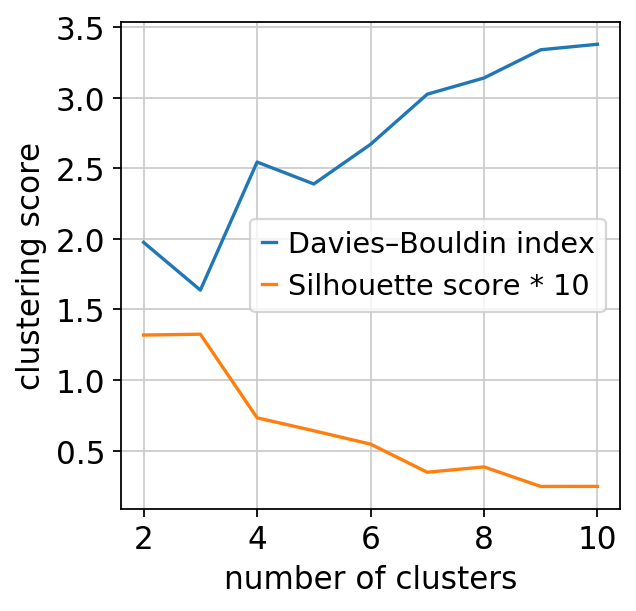

In [32]:
# plot the top value for each cluster

plt.plot(min_db['number_of_clusters'], min_db['davie_bould'])
plt.plot(max_sil['number_of_clusters'], min_db['sil'] * 10)
plt.legend(['Davies–Bouldin index','Silhouette score * 10'])
plt.xlabel('number of clusters')
plt.ylabel('clustering score')
plt.show

plot the maximum values for Silhouette score and minimum values from Davies-Bouldin index for specific clusters

In [33]:
results_df[results_df['number_of_clusters'] == 6].sort_values('davie_bould', ascending=True) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  20         0.5                 6.0  0.054672     2.669349
0  20         0.6                 6.0  0.037838     2.791696
0  15         0.6                 6.0  0.039681     2.856681
0  35         0.7                 6.0  0.042342     2.898980
0  10         0.6                 6.0  0.054524     2.995868
0  40         0.7                 6.0  0.047230     3.160741
0  35         0.8                 6.0  0.044861     3.383214
0  25         0.8                 6.0  0.038218     3.451918
0  45         0.8                 6.0  0.054175     3.476462

In [34]:
results_df[results_df['number_of_clusters'] == 5].sort_values('sil', ascending=False) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  10         0.5                 5.0  0.074143     2.515733
0  25         0.7                 5.0  0.067804     2.666246
0  45         0.7                 5.0  0.064208     2.626423
0  10         0.4                 5.0  0.064118     2.388809
0  30         0.7                 5.0  0.059413     3.113614

In [35]:
results_df[results_df['number_of_clusters'] == 4].sort_values('sil', ascending=False) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  35         0.6                 4.0  0.075314     2.618198
0  25         0.5                 4.0  0.075175     2.618091
0  45         0.5                 4.0  0.074978     2.564836
0  35         0.5                 4.0  0.074775     2.564255
0  40         0.6                 4.0  0.074353     2.669542
0  25         0.6                 4.0  0.074340     2.825666
0  40         0.5                 4.0  0.074255     2.578436
0  25         0.4                 4.0  0.074133     2.555986
0  45         0.4                 4.0  0.073724     2.547522
0  30         0.6                 4.0  0.073506     2.848448
0  20         0.4                 4.0  0.073499     2.561493
0  15         0.5                 4.0  0.073489     2.633443
0  40         0.4                 4.0  0.073425     2.546441
0  35         0.4                 4.0  0.073297     2.544031
0  30         0.5                 4.0  0.073203     2.842505
0  30         0.4                 4.0  0.073154     2.552644
0  15         0.4                 4.0  0.072871     2.570808
0  10         0.3                 4.0  0.072767     2.559659
0   5         0.4                 4.0  0.067386     3.010486
0   5         0.3                 4.0  0.067370     2.976414
0  45         0.6                 4.0  0.067174     2.694105

In [36]:
results_df[results_df['number_of_clusters'] == 3].sort_values('sil', ascending=False) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  25         0.2                 3.0  0.141095     1.670453
0  20         0.2                 3.0  0.139716     1.724096
0  15         0.2                 3.0  0.138249     1.716243
0  10         0.2                 3.0  0.137165     1.716760
0   5         0.2                 3.0  0.135912     1.727792
0  35         0.3                 3.0  0.134494     1.732771
0  30         0.3                 3.0  0.134464     1.737955
0  45         0.3                 3.0  0.133972     1.749752
0  40         0.3                 3.0  0.133629     1.736149
0  15         0.3                 3.0  0.133322     1.745049
0  20         0.3                 3.0  0.132634     1.757616
0  25         0.3                 3.0  0.132570     1.757695
0  35         0.2                 3.0  0.132487     1.636970
0  30         0.2                 3.0  0.132171     1.638994
0  40         0.2                 3.0  0.131243     1.643830

### UMAP with different numbers of neighbors - based on the scores above

#### Leiden 3 clusters 25 KNN, 0.2 resolution

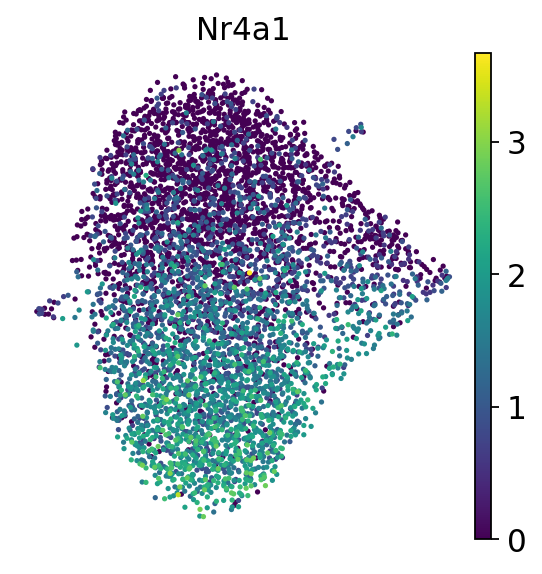

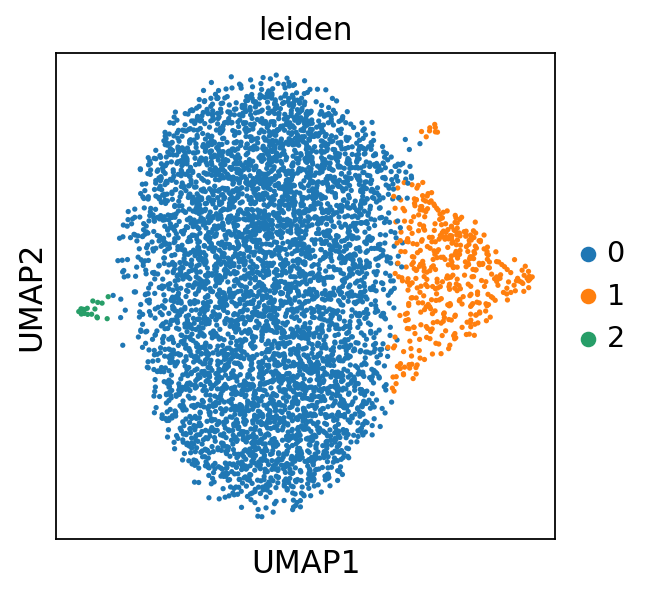

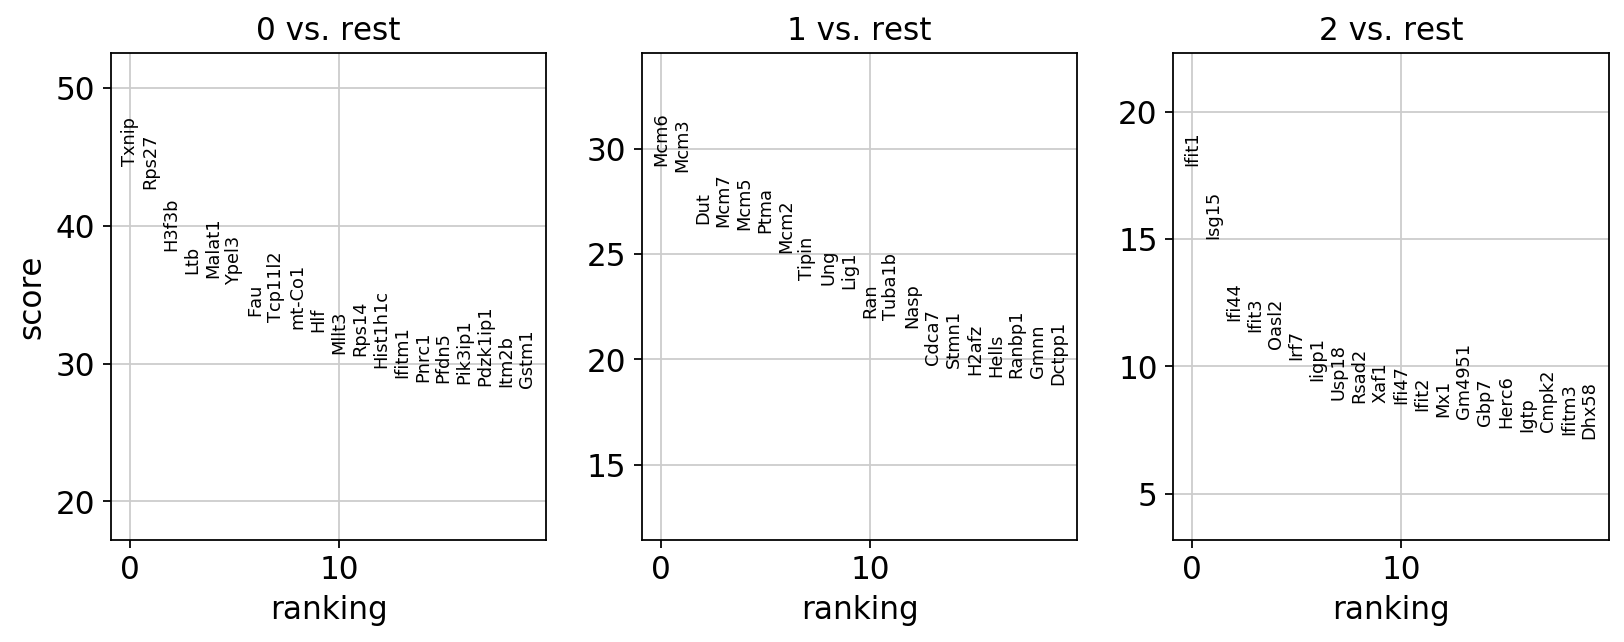

In [37]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.2)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### Leiden 4 clusters 35 KNN, 0.6 resolution

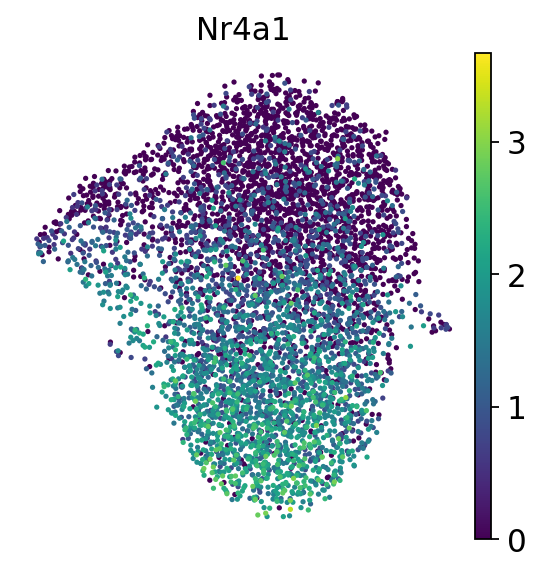

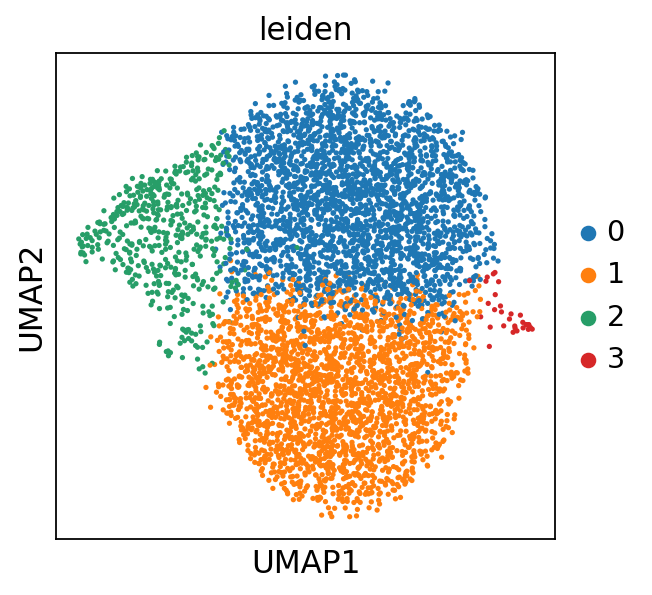

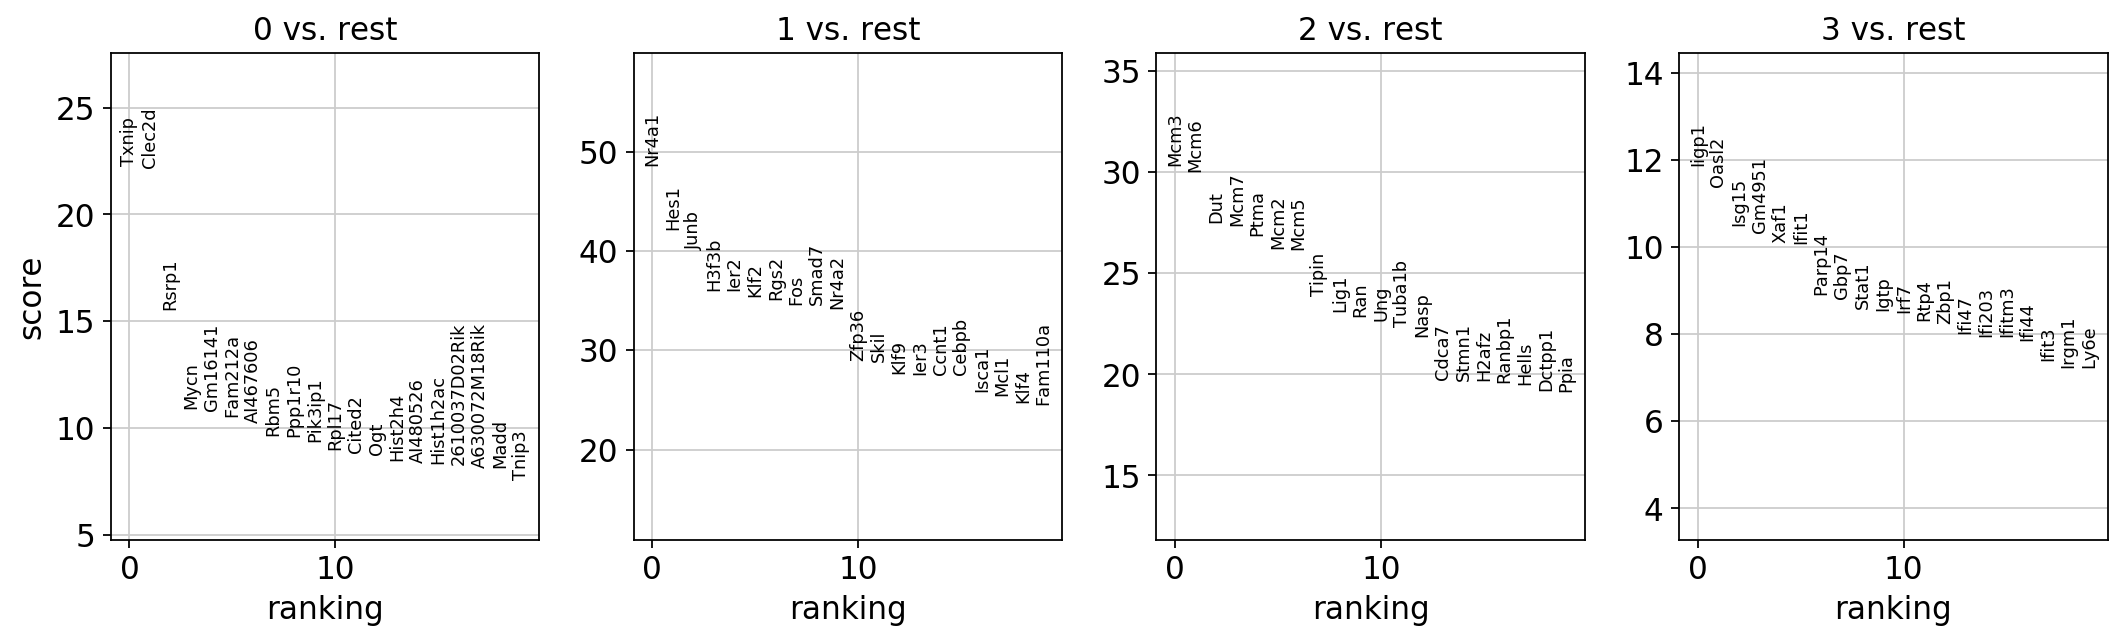

In [38]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=35, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### Leiden 5 clusters 10 KNN, 0.5 resolution

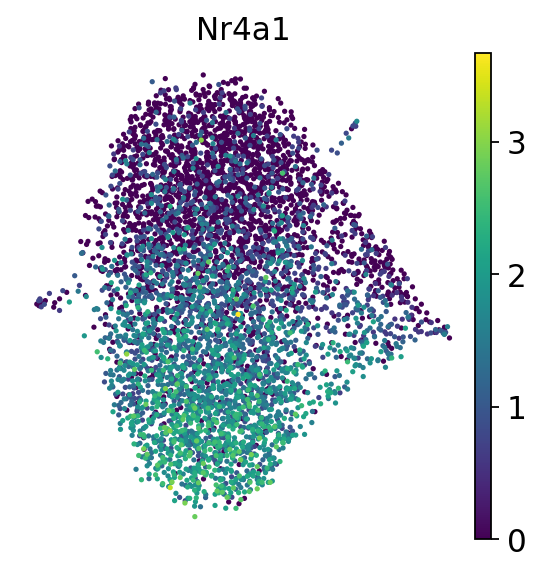

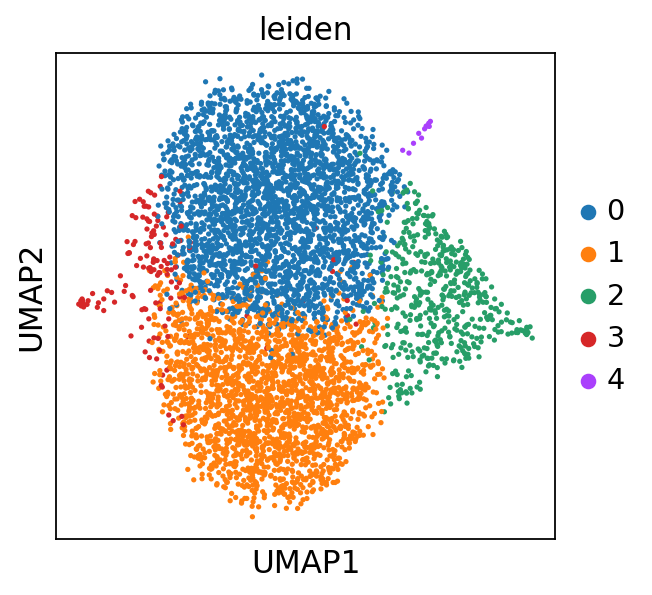

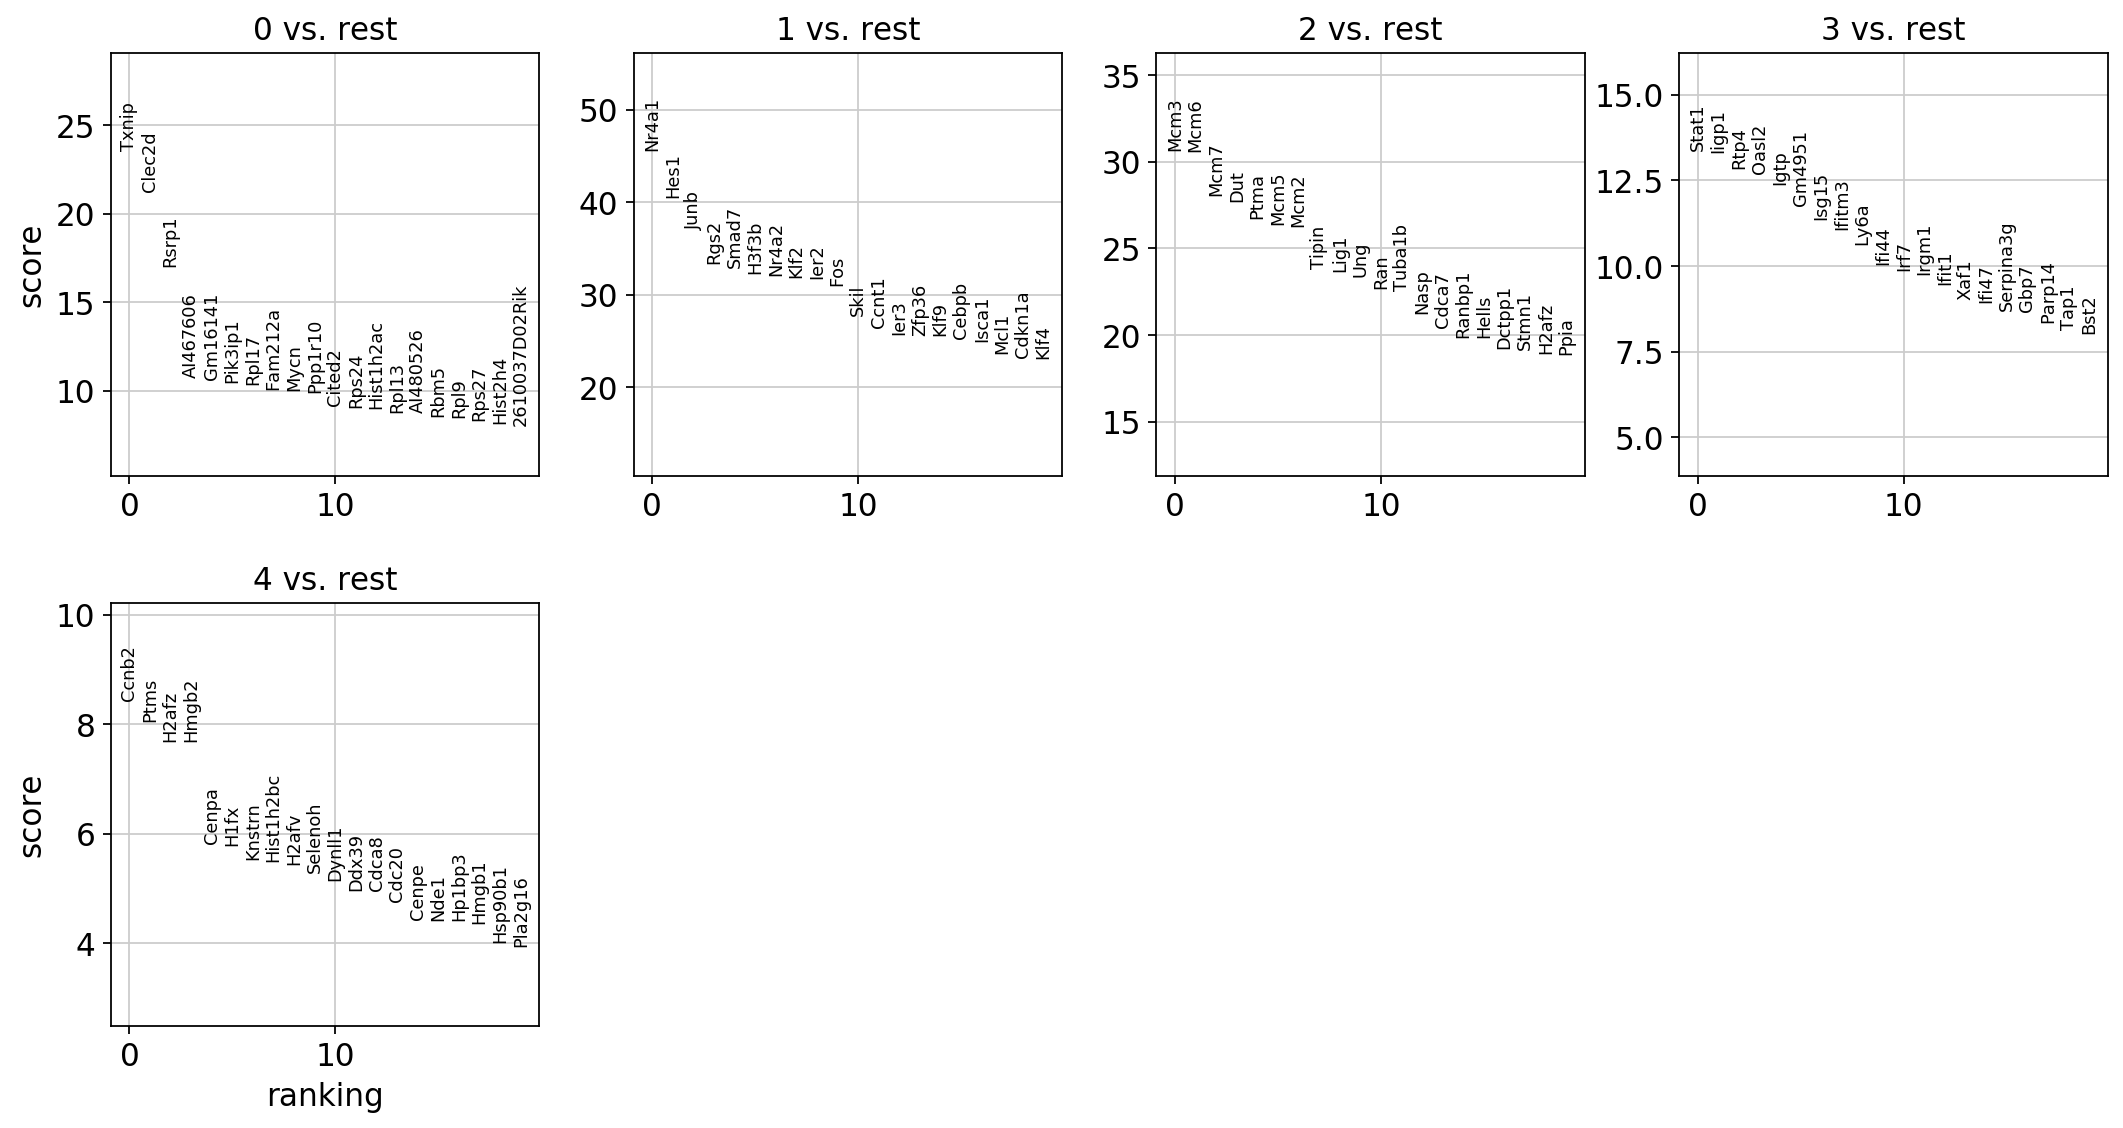

In [39]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### 6 clusters 20 KNN, 0.6 resolution

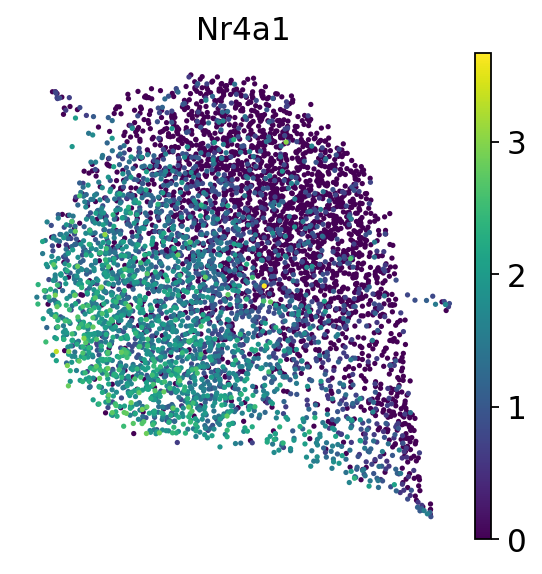

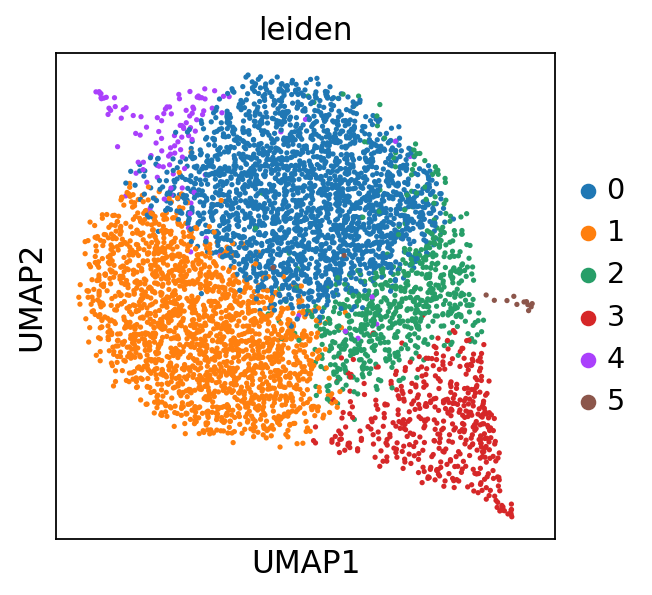

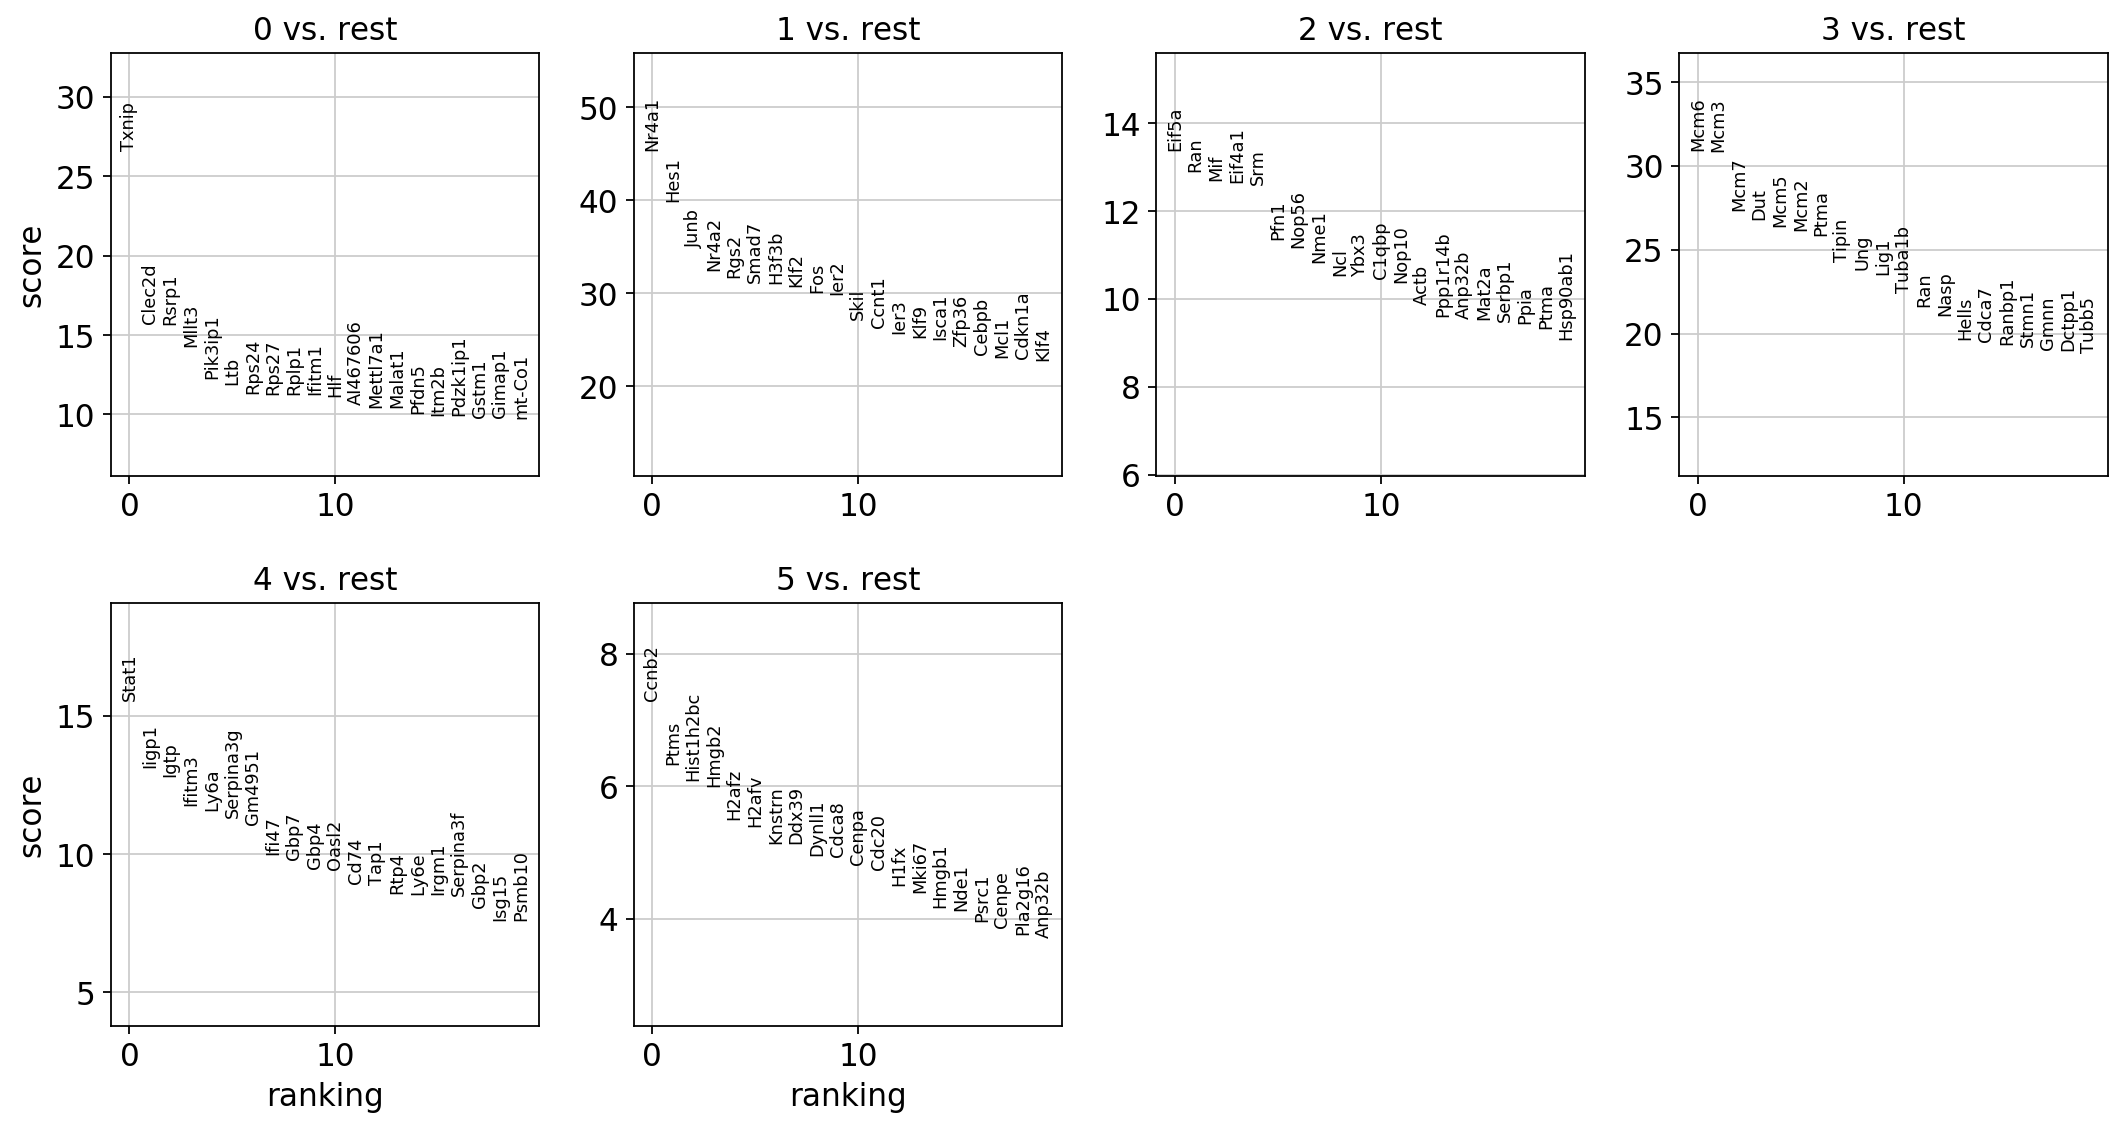

In [40]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

### 7) Move forward with cluster combination

#### Leiden 4 clusters 35 KNN, 0.6 resolution

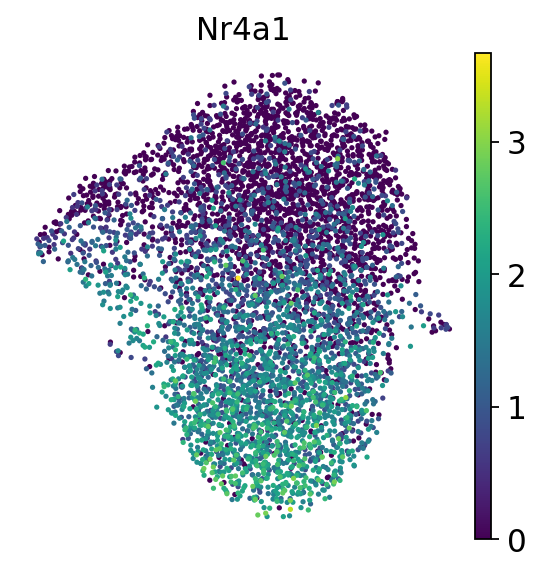

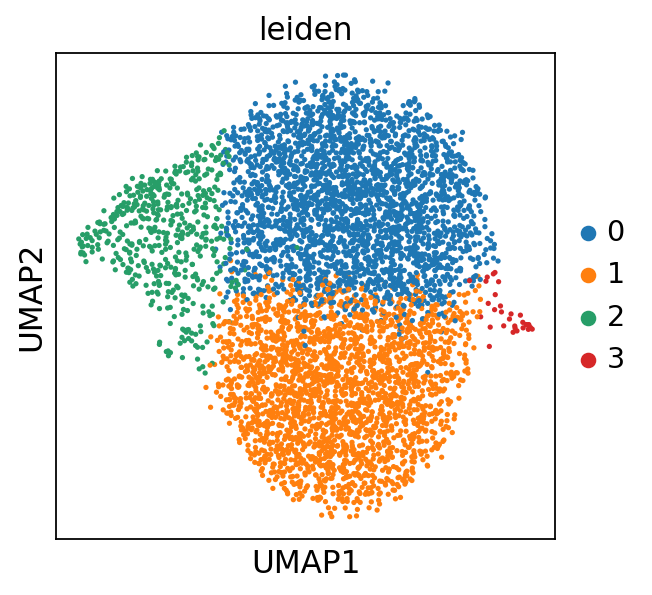

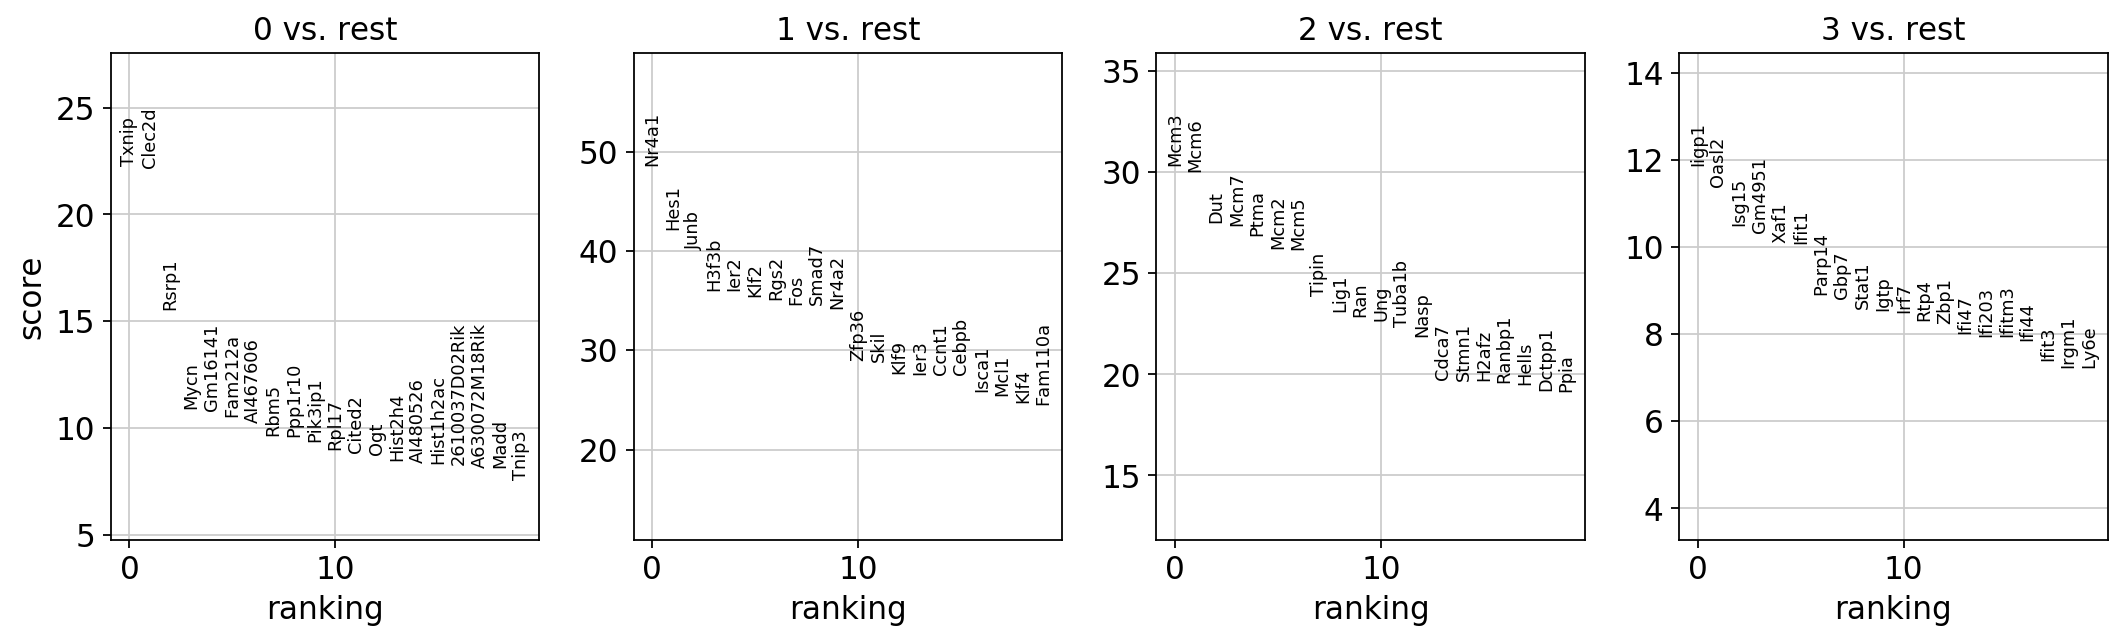

In [41]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=35, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [45]:
# rename cluster categories
adata.rename_categories('leiden', ['Quiescent', 'Activated', 'Metabolism', 'Interferon'])

In [46]:
adata.uns['leiden_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#aa40fc', '#d62728', '#8c564b']

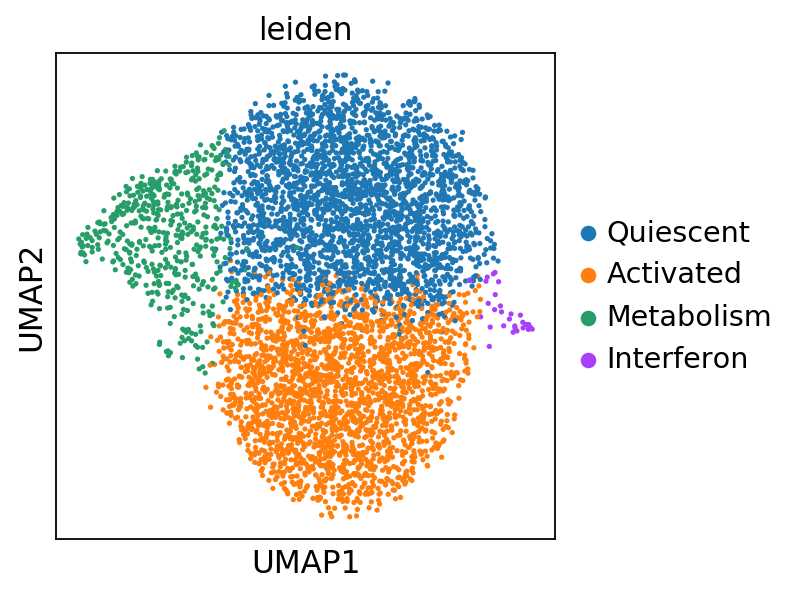

In [47]:
sc.pl.umap(adata, color='leiden', frameon=True, save='_new_ct_LT.pdf')

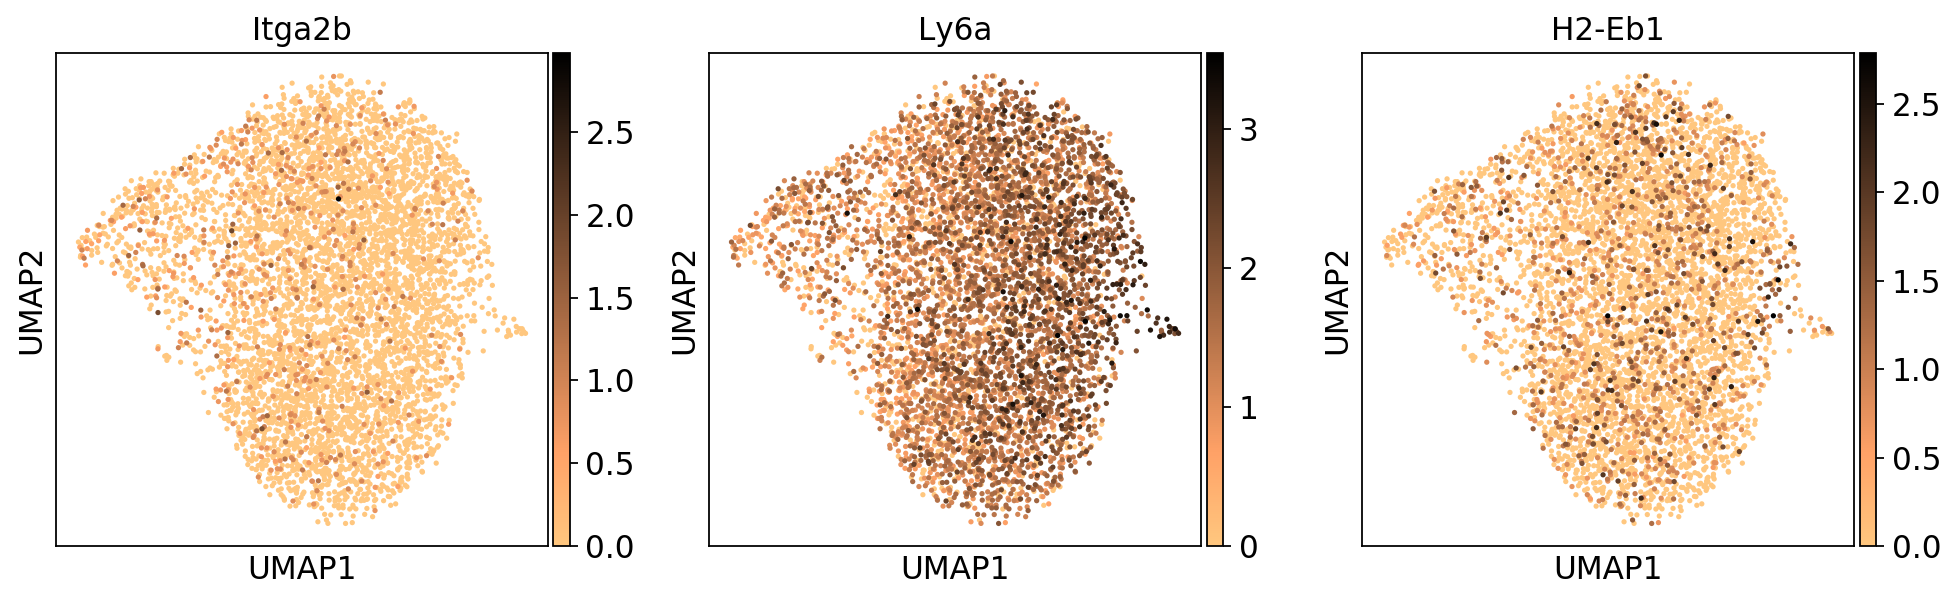

In [48]:
sc.pl.umap(adata, color = ['Itga2b', 'Ly6a', 'H2-Eb1'], cmap = 'copper_r', save='_new_ct_LT_Itga2b_Ly6a_H2-Eb1.pdf')

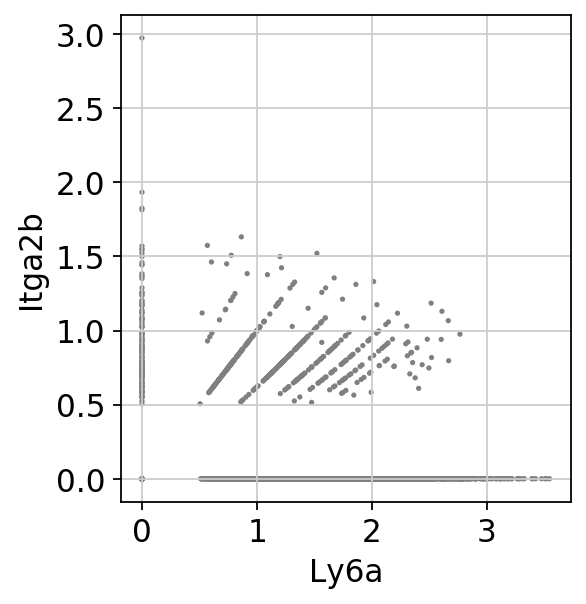

In [49]:
sc.pl.scatter(adata, x='Ly6a', y='Itga2b', save = '_new_ct_LT_scatter_Itga2b_Ly6a.pdf')

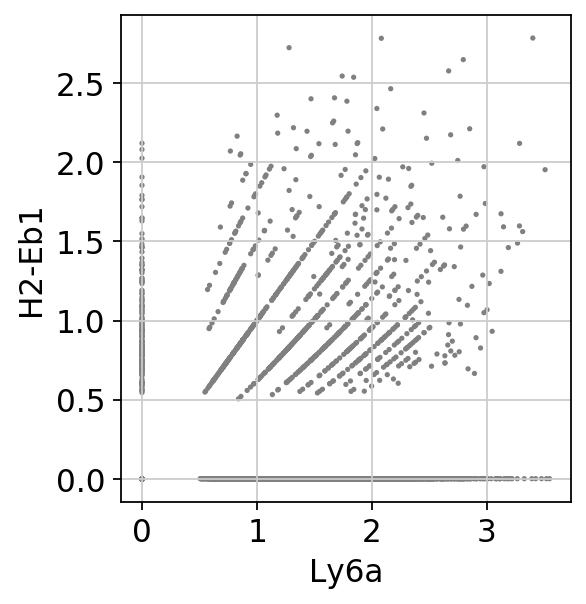

In [50]:
sc.pl.scatter(adata, x='Ly6a', y='H2-Eb1', save = '_new_ct_LT_scatter_Itga2b_H2-Eb1.pdf')

In [51]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

In [52]:
enrichment_clusters

Quiescent_n  Quiescent_s Activated_n  Activated_s Metabolism_n  \
0        Txnip    22.294632       Nr4a1    48.622177         Mcm3   
1       Clec2d    22.164490        Hes1    42.123001         Mcm6   
2        Rsrp1    15.520906        Junb    40.118328          Dut   
3         Mycn    10.915593       H3f3b    35.973621         Mcm7   
4      Gm16141    10.791975        Ier2    35.940273         Ptma   
..         ...          ...         ...          ...          ...   
95     Gm17473     4.859793       Hspa5    11.107095       Mrpl18   
96        Tia1     4.844184       Mapk6    11.087958         Ezh2   
97        Guf1     4.830636      Ptp4a1    11.061901        Ssrp1   
98      Rpl18a     4.829197       Dyrk3    10.982834        Banf1   
99     Gm44777     4.789119       Ndel1    10.931694          Tkt   

    Metabolism_s Interferon_n  Interferon_s  
0      30.333117        Iigp1     11.872274  
1      30.019775        Oasl2     11.382495  
2      27.477684        Isg15     10.487597  
3      27.346546       Gm4951     10.316038  
4      26.834818         Xaf1     10.102091  
..           ...          ...           ...  
95     12.149611        Mov10      3.403670  
96     11.920335         Irf1      3.339669  
97     11.885616      Tmem140      3.315809  
98     11.880320         Irf9      3.287476  
99     11.830419     AW011738      3.283616  

[100 rows x 8 columns]

In [53]:
enrichment_clusters.to_csv('./write/new_LT_clusters.csv', index=False, header=True)

In [54]:
# Annotate the data sets
print(adata.obs['leiden'].value_counts())
print('')

Quiescent     2614
Activated     2196
Metabolism     493
Interferon      31
Name: leiden, dtype: int64



In [59]:
# have to delete that otherwise there is a bug in the saving to .h5ad
adata.uns['rank_genes_groups'] = None
adata.uns['rank_genes'] = None

In [60]:
# write the file to disk
adata.write('./sc_objects/new_ct_LT_preprocessed.h5ad')

In [56]:
cell_numbers = pd.DataFrame(adata.obs['leiden'].value_counts())

In [57]:
cell_numbers.to_csv('./write/new_LT_cell_numbers.csv', index=True, header=True)

In [58]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1.post1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : 1.2.8
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          :